# Import utils and getting the data

In [94]:
import io
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

Download the IMDb Dataset

In [95]:
#os.path.dirname('TFExamTest/word_embeddings/')

In [96]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [97]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [98]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

# Create Train and validation Datasets

In [122]:
batch_size = 1024
seed = 123
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2,
    subset='training', seed=seed)
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2,
    subset='validation', seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [123]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


## Explore the data set

In [124]:
for text_batch, label in raw_train_ds.take(1):
    for i in range(3):
        print('\n','Text:','\n', text_batch[i], '\n')
        print('Labels:', '\n', label[1])


 Text: 
 tf.Tensor(b"Oh My God! Please, for the love of all that is holy, Do Not Watch This Movie! It it 82 minutes of my life I will never get back. Sure, I could have stopped watching half way through. But I thought it might get better. It Didn't. Anyone who actually enjoyed this movie is one seriously sick and twisted individual. No wonder us Australians/New Zealanders have a terrible reputation when it comes to making movies. Everything about this movie is horrible, from the acting to the editing. I don't even normally write reviews on here, but in this case I'll make an exception. I only wish someone had of warned me before I hired this catastrophe", shape=(), dtype=string) 

Labels: 
 tf.Tensor(1, shape=(), dtype=int32)

 Text: 
 tf.Tensor(b'This movie is SOOOO funny!!! The acting is WONDERFUL, the Ramones are sexy, the jokes are subtle, and the plot is just what every high schooler dreams of doing to his/her school. I absolutely loved the soundtrack as well as the carefully pla

Notice the reviews contain raw text (with punctuation and occasional HTML tags like *< br/ >*).

In [125]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


# Prepare the dataset for training

We will standardize, tokenize, and vectorize the data using the helpful [tf.keras.layers.TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer.

In [103]:
def custom_standardization(input_data):
    '''Standarize the input text transforming into lowecarse, stripping the text removing <br> HTML tags 

    Args:
        input_data (list or str): Input text

    Returns:
        Tensor: String processed
    '''
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),'')

In [104]:
custom_standardization('hola')
custom_standardization(['Hola', 'adios'])

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'hola', b'adios'], dtype=object)>

Next we will define a TextVectorization layer

In [105]:
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, we will call adapt to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

**Note: It's important to only use your training data when calling adapt (using the test set would leak information).**

In [126]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [107]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [127]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'It\'s always nice to see Angela Bassett getting to do a role that she can really sink her teeth into. She is at times intense, funny and even sexy in her role as Lena, a "colored" woman forced to make a home on a desolate mudbank just outside of Cape Town, South Africa. Danny Glover is also good in a not entirely sympathetic role as her partner, Boesman. Willie Jonah gives a finely nuanced performance as the stranger that discovers Boesman and Lena\'s new living area. It\'s not often that you get a chance to see an intelligent film dealing with mature themes. Although it is based on a play, the late director John Berry (who also directed Claudine) opens the material up by having the film shot in the widescreen Cinemascope format. He also keeps things visually interesting through the creative blocking of actors and by showing us things only mentioned in the play. Just like Diahann Carroll in Claudine, John Berry may have directed Angela Bassett into an Academy Award n

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling .get_vocabulary() on the layer.



In [109]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  walking
 313 --->  idea
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.



In [128]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_val_ds.map(vectorize_text)

In [129]:
for text, label in train_ds.take(1):
    print(text, label)

tf.Tensor(
[[  10  255   11 ...    0    0    0]
 [  11 1367  106 ... 7931  125    1]
 [ 199  324   46 ...    0    0    0]
 ...
 [ 462   29 1969 ...    0    0    0]
 [ 142   21  600 ...    0    0    0]
 [  10   68 7596 ...    4    1 1243]], shape=(1024, 250), dtype=int64) tf.Tensor([1 0 1 ... 0 1 1], shape=(1024,), dtype=int32)


## Configure the dataset for performance

**.cache()** keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

**.prefetch()** overlaps data preprocessing and model execution while training.

In [130]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the Model

In [113]:
embedding_dim = 16

In [114]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(max_features + 1, embedding_dim),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_4 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
________________________________________________

In [115]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [116]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [117]:
val_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [131]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
20/20 [==============================] - 6s 201ms/step - loss: 0.6433 - binary_accuracy: 0.7628 - val_loss: 0.6416 - val_binary_accuracy: 0.7462
Epoch 2/10
20/20 [==============================] - 0s 15ms/step - loss: 0.6359 - binary_accuracy: 0.7660 - val_loss: 0.6345 - val_binary_accuracy: 0.7498
Epoch 3/10
20/20 [==============================] - 0s 13ms/step - loss: 0.6282 - binary_accuracy: 0.7703 - val_loss: 0.6273 - val_binary_accuracy: 0.7554
Epoch 4/10
20/20 [==============================] - 0s 13ms/step - loss: 0.6204 - binary_accuracy: 0.7752 - val_loss: 0.6198 - val_binary_accuracy: 0.7576
Epoch 5/10
20/20 [==============================] - 0s 13ms/step - loss: 0.6121 - binary_accuracy: 0.7797 - val_loss: 0.6122 - val_binary_accuracy: 0.7616
Epoch 6/10
20/20 [==============================] - 0s 13ms/step - loss: 0.6044 - binary_accuracy: 0.7842 - val_loss: 0.6046 - val_binary_accuracy: 0.7648
Epoch 7/10
20/20 [==============================] - 0s 13ms/step - lo

In [132]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

5/5 [==============================] - 1s 64ms/step - loss: 0.5740 - binary_accuracy: 0.7828
Loss:  0.5739613175392151
Accuracy:  0.782800018787384


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

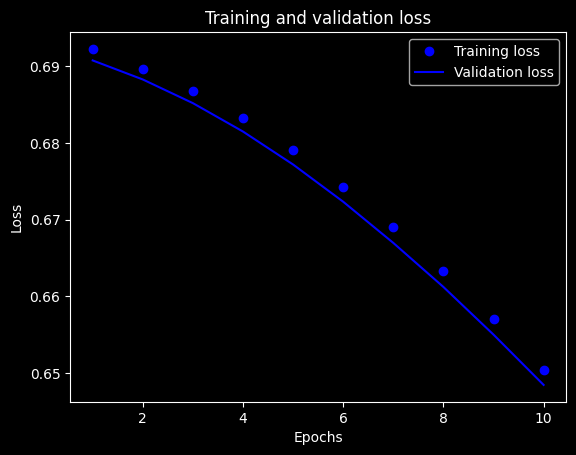

In [133]:
import matplotlib.pyplot as plt
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

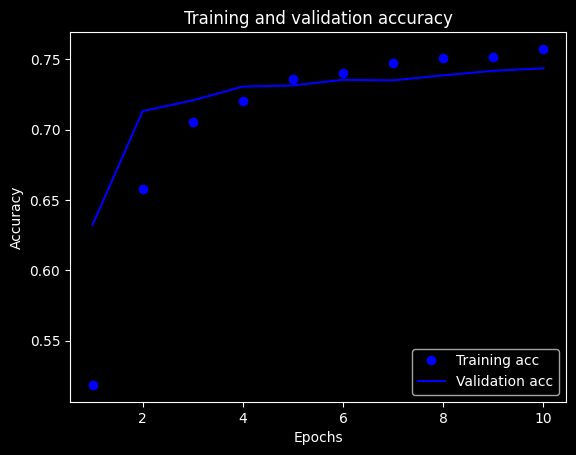

In [134]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [135]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/20
20/20 [==============================] - 0s 17ms/step - loss: 0.5633 - binary_accuracy: 0.8044 - val_loss: 0.5665 - val_binary_accuracy: 0.7868
Epoch 2/20
20/20 [==============================] - 0s 15ms/step - loss: 0.5549 - binary_accuracy: 0.8105 - val_loss: 0.5589 - val_binary_accuracy: 0.7912
Epoch 3/20
20/20 [==============================] - 0s 13ms/step - loss: 0.5468 - binary_accuracy: 0.8145 - val_loss: 0.5516 - val_binary_accuracy: 0.7954
Epoch 4/20
20/20 [==============================] - 0s 13ms/step - loss: 0.5393 - binary_accuracy: 0.8181 - val_loss: 0.5443 - val_binary_accuracy: 0.8006
Epoch 5/20
20/20 [==============================] - 0s 13ms/step - loss: 0.5308 - binary_accuracy: 0.8220 - val_loss: 0.5372 - val_binary_accuracy: 0.8052
Epoch 6/20
20/20 [==============================] - 0s 13ms/step - loss: 0.5235 - binary_accuracy: 0.8256 - val_loss: 0.5301 - val_binary_accuracy: 0.8060
Epoch 7/20
20/20 [==============================] - 0s 14ms/step - los

# Export the Model

In the code above, you applied the *TextVectorization* layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the *TextVectorization* layer inside your model. To do so, you can create a new model using the weights you just trained.



In [137]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  tf.keras.layers.Activation('sigmoid')
])

export_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

25/25 [==============================] - 26s 691ms/step - loss: 0.4636 - accuracy: 0.8288
0.828760027885437


## Predict on new data

In [138]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 132ms/step


array([[0.54963225],
       [0.51560134],
       [0.50971365]], dtype=float32)